# Introduction to RL

This notebook is my playing around with Reinforcement learning models. It can be thought of as a `hello world` notebook to setup Cuda, CuDNN, aigym etc. I plan to solve a couple of aigym problems using various techniques.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gym import wrappers, envs
import time

## CartPole-v0

The cartpole problem is typically the first problem analysed in RL. It consists of an inverted pendulum on a 1d slide. The aim is to keep the pendulum vertical by moving the cart either left or right in reponse to it falling over. The game ends when the pole's lean exceeds 15 degrees or the slide moves out of the playing area. Below I have implemented a number of techniques for solving this problem in order of increasing complexity.

The state space looks like `cart position, cart velocity, pole angle, pole velocity at tip`.

The action space looks like `move left, move right`.

AiGym keep excellent documentation on each of their environments on their [github page](https://github.com/openai/gym/wiki/CartPole-v0)

### Dumb Solution with Random actions

We are going to run our simulation to completion taking random actions each step. This is to familiarise us with the AIGym, how to start it, how to step it, how to get a reward and how to tell when it is finished.

In [2]:
# Initialise the CartPole-v0 problem.
env = gym.make('CartPole-v0')
TotalReward=0
done=False
observation=env.reset()
# Loop until the pole falls.
while not done:
    # Render the environment to screen.
    env.render()
    # Pause such that this loop creates a 10Hz movie of the system.
    time.sleep(0.1)
    # Choose a random action
    action=env.action_space.sample()
    # Enact the chosen action and recieve a reward.
    observation, reward, done, info = env.step(action)
    TotalReward+=reward
    if done:
        break
    
print("Reward was: ",TotalReward)
env.close()

Reward was:  13.0


### Monte Carlo policy search Solution

Next we are going to create a vector with random numbers and take the dot product of this random vector with the present state vector. We are then going to take an action depending on the sign of this dot product. This is a policy search solution.

We will then search for the random vector that gives the highest reward.

Note that in this example we do not render the environment which leads to a large speedup.

best length is 79.22
best length is 79.22
best length is 200.0
best length is 200.0
best length is 200.0
best length is 200.0
best length is 200.0
best length is 200.0
best length is 200.0
best length is 200.0
Game with best weights ran for  200.0  turns


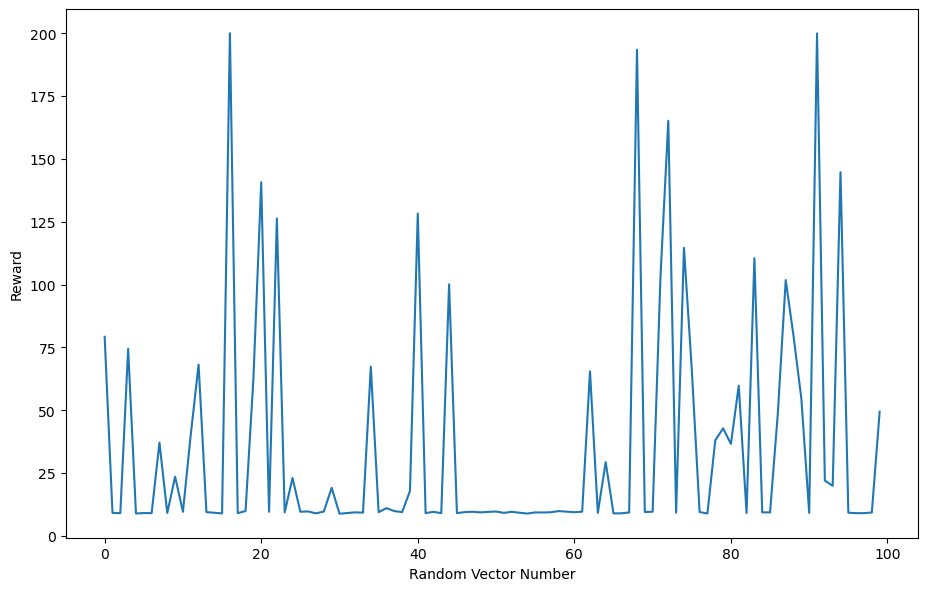

In [23]:
# Initialise the CartPole-v0 problem.
# Note that this problem ends after 200 steps.
env = gym.make('CartPole-v0')
bestLength=0
episode_lengths=[]

best_weights=np.zeros(4)
# Loop over 100 random vectors.
for i in range(100):
    new_weights= np.random.uniform(-1.0,1.0,4)

    # try this vector 100 times to give an average reward.
    # store the reward of each trial in the list length
    length=[]
    for j in range(100):
        done=False
        observation = env.reset()
        TotalReward=0
        
        while not done:
            
            # Take dot products of new_weights with observations
            # i.e. a 1x4 tensor * 4x1 tensor -> scalar.
            # result = +ve move right
            #        = -ve move left
            action = 1 if np.dot(new_weights,observation) > 0 else 0
            observation, reward, done, info = env.step(action)
            TotalReward+=reward
            if done:
                break
        length.append(TotalReward)
    # Calc. the average reward    
    average_length=float(sum(length)/len(length))
    # If these weights are better, keep them.
    if average_length > bestLength:
        bestLength = average_length
        best_weights = new_weights
    episode_lengths.append(average_length)
    if i % 10 == 0 :
        print('best length is', bestLength)

# Plot the reward history.
fig=plt.figure(figsize=(11,7), dpi=100)
plt.plot(episode_lengths)
plt.xlabel('Random Vector Number')
plt.ylabel('Reward')
        
# Show the best weights in action
done=False
TotalReward=0
observation=env.reset()
while not done:
    # Show movie @ 50Hz.
    env.render()
    time.sleep(0.02)
    action = 1 if np.dot(best_weights, observation) > 0 else 0
    observation, reward, done, info = env.step(action)
    TotalReward+=reward
    if done:
        break
        
env.close()        
print("Game with best weights ran for ",TotalReward, " turns")

### Deep Learning Solution

This section is based on the pytorch documentation. I have attempted to remove the Convolutional Neural Net approach to extracting the state space and replaced it with the state space directly from the environment.

In [37]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cpu for simulation.


#### Replay memory

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:

   `Transition` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the state vector returned from the `env.step()` method.
   
   `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [38]:
'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        
        return len(self.memory)

Now, let’s define our model. But first, let quickly recap what a DQN is.

### DQN algorithm

Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. In the reinforcement learning literature, they would also contain expectations over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted, cumulative reward 

$$ R_{t0}=\sum^{\infty}_{t=t_0} \gamma^{t−t_0}r_t $$,

where $R_{t0}$ is also known as the return. The discount, $\gamma$, should be a constant between 0 and 1 that ensures the sum converges. It makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function 

$$ Q^∗:State×Action\rightarrow R$$, 

that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:

$$ \pi^*(s)= \text{argmax}_a   Q^*(s,a) $$

However, we don’t know everything about the world, so we don’t have access to $Q^∗$. But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^∗$.

For our training update rule, we’ll use a fact that every $Q$ function for some policy obeys the Bellman equation:

$$ Q^π(s,a)=r+\gamma Q^π(s′,π(s′)) $$ 

The difference between the two sides of the equality is known as the temporal difference error, $\delta$: 


$$ \delta=Q(s,a)−(r+\gamma \text{max}_a Q(s′,a)) $$

To minimise this error, we will use the Huber loss. The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of Q are very noisy. We calculate this over a batch of transitions, B, sampled from the replay memory:

$$ \mathcal{L}=\frac{1}{|B|} \sum_{(s,a,s',r)\in B} \mathcal{L}(\delta) $$


$$\begin{split}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}\end{split}
$$


### Q-network

Our model will be a fully connected neural network that takes in state space and has two outputs, representing `Q(s,left)`
and `Q(s,right)` (where s is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

In [39]:
class DQN(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        # inputs are the 4 vector state space
        self.FCL1 = nn.Linear(4,16)
        self.FCL2 = nn.Linear(16,64)
        self.FCL3 = nn.Linear(64,16)
        self.FCL4 = nn.Linear(16,2)
        # Output is a Q value allocated to each action.
        #
        #       input    hidden   hidden  hidden  output
        #       layer    layer1   layer2  layer3  layer
        #size    4         16       64      16      2

    def forward(self, x):
        x = F.relu(self.FCL1(x))
        x = F.relu(self.FCL2(x))
        x = F.relu(self.FCL3(x))
        x = F.relu(self.FCL4(x))
        return x

We are going to implement an epsilon-greedy DQN. 

In this network at each step we can choose to follow the optimal policy given by the policy network(exploit), or we can randomly choose an action in the hope of finding a new state (explore). 

The below functions show the probability of exploring as a function of episode. Initially we want to exclusively explore as we cannot update out Policy network until we have enough transitions in memory to fit into a batch for SGD.

In [40]:
def epsilon_threshold (steps, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''float -> float
    
    Return the probabilty of selecting exploration in a RL step.
    '''

    return min(EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps / EPS_DECAY),1.0)

def plot_eps (max_steps=1000,EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 200):
    '''int,float,float,int -> None
    
    Plot the probability of an exploration step vs number of steps.
    
    max_steps:    Maximum number of steps to plot
    EPS_START:    Initial Probabilty at step=0
    EPS_END:      Final probability at step=infinity
    EPS_DECAY:    Sort of like a Half-life of decay in steps'''
    
    epsilon=[]
    steps=[]
    for step in range(max_steps):
        steps.append(step)
        epsilon.append(epsilon_threshold(step,EPS_START=EPS_START, EPS_END=EPS_END,EPS_DECAY=EPS_DECAY))


    fig=plt.figure()
    plt.ylim((0,1.05))
    plt.xlim((0,max_steps))
    plt.xlabel("Steps")
    plt.ylabel("Probability of exploration")
    plt.plot(steps,epsilon)
    plt.show()
    return None

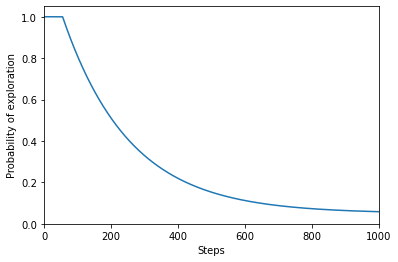

In [67]:
BATCH_SIZE = 256
# Discount Factor
GAMMA = 0.999

# Define epsilon greedy behaviour with 3 parameters.
# Note we want to explore exclusively initially.
EPS_START = 1.3
EPS_END = 0.05
EPS_DECAY = 200.0

# Plot what our epsilon values look like.
plot_eps(1000,EPS_START,EPS_END,EPS_DECAY)

# How often do we update our policy network parameters (in steps)
TARGET_UPDATE = 10

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get length of state space from gym observation space
n_states = env.observation_space.shape[0]

# Create two networks
policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_net.load_state_dict(policy_net.state_dict())

target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
# Initialise the memory object.
memory = ReplayMemory(200000)

steps_done = 0


def select_action(state):
    '''??? -> torch
    
    Chooses an epsilon-greedy action given an input state.'''
    global steps_done
    sample = random.random()
    eps_threshold = min(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY),1.0)
    steps_done += 1
    if sample > eps_threshold:
        # Exploitation
        #print('Exploiting')
        with torch.no_grad():
            
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Exploration
        #print('Exploring')
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    '''Show the numder of durations per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,figsize=(20,10)) 
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())

env.close()

In [68]:
def optimize_model():
    '''
    None -> None
    
    Update the DQN policy network via SGD.
    '''
    if len(memory) < BATCH_SIZE:
        print("Warning: We do not have enough history in memory to optimize our network")
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))


    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #                     policy_net(state_batch) 
    #                        outputs the Q(s_t) for all actions. (i.e. a nx2 tensor)
    #                     .gather(1,action_batch) 
    #                         Selects the Q(s_t) value of the action taken
    #                     This gives Q(s_t, a)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # THis is a Boolean array with True for non-final states.
    # Question: Why does it need to be cast to a tuple?
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # This is a float array containing the state values.
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Initialise all values as Zero (i.e. all next_states are final.)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # Update the non-final states with the predicted values from the current value network.
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    ## Zero all gradients
    ### i.e. x.grad =0
    optimizer.zero_grad()
    ## Perform backward pass (calculate dloss/dx for all parameters x.)
    ### i.e x.grad += dloss/dx for all x.
    loss.backward()
    ## Clip Gradients to +/- 1
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    ## Update all parameters.
    ###  i.e. x += -lr * x.grad
    optimizer.step()


Complete


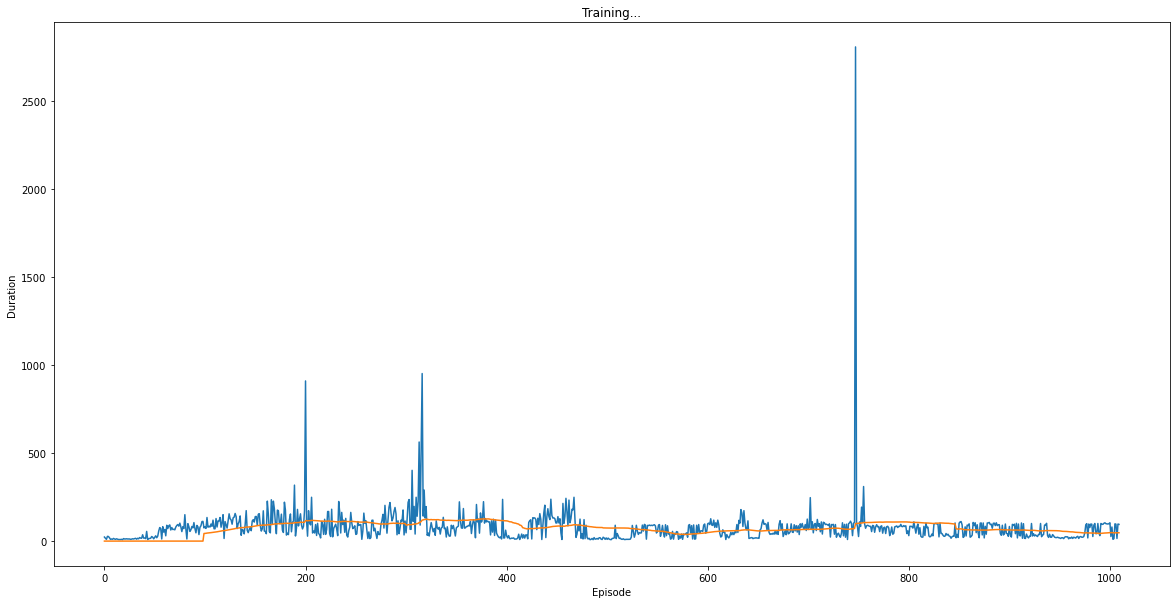

In [71]:
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state, reward, done, _ = env.step(1)
    state = torch.from_numpy(np.cast['float32'](state)).unsqueeze(0).to(device)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        #env.render()
        # Return the environment parameters.
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)

        reward = torch.tensor([reward], device=device)

        # If this transition caused the simulation to exit, set the next state to None.
        if not done:
            next_state = next_state
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done or t >= 5000:
            # Cap simulations at 5000 steps.
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    if i_episode % TARGET_UPDATE == 0:
        # Update the target network, copying all weights and biases in DQN
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()
plot_durations()

In [70]:
sum(episode_durations[-10:])

168

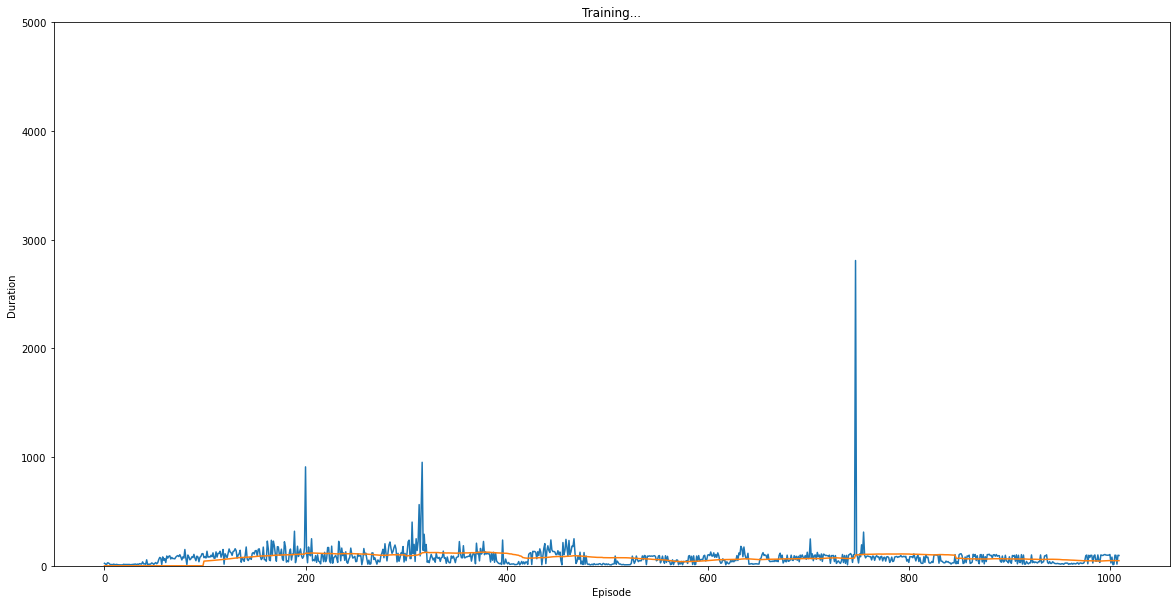

In [73]:
def plot_final_durations():
    plt.figure(2,figsize=(20,10))
    #plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.ylim((0,5000))
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.1)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        
plot_final_durations()

### Full Deep learning Solution

This is from the pytorch documentation on reinforcement learning.

This is a slightly more complicated RL solution: it extracts the state space directly from differences in adjacent rendered images using a convolutional neural net. This is a more general solution to AIGym games and extends to anything with an image output.

In [12]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cpu for simulation.


In [13]:
class DQN(nn.Module):
    '''A Deep Q network to use a CNN to determine Q'''

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#### Input extraction

The code below are utilities for extracting and processing rendered images from the environment. It uses the torchvision package, which makes it easy to compose image transforms. Once you run the cell it will display an example patch that it extracted.

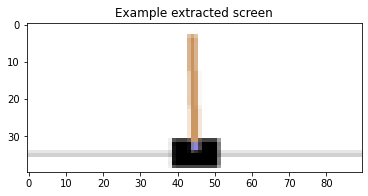

In [14]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [15]:
env.close()

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())

In [17]:
env.close()

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


Below, you can find the main training loop. At the beginning we reset the environment and initialize the state Tensor. Then, we sample an action, execute it, observe the next screen and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.

Below, num_episodes is set small. You should download the notebook and run lot more epsiodes, such as 300+ for meaningful duration improvements.

In [19]:
num_episodes = 200
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

Complete


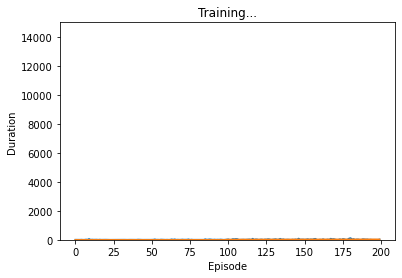

In [20]:
plot_final_durations()

In [72]:
env.close()